In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pprint
import seaborn as sns

In [2]:
df = pd.read_csv(f"out/study/scores.csv")
df_f = df[df.pilot == 0]
df_f.head(60)

,id,version,sus,pretest,score,pilot
0,seal,A,47.5,0.86,0.74,0
1,zebra,B,95.0,0.93,0.55,0
2,lion,A,77.5,0.71,0.68,0
3,lemur,B,50.0,0.71,0.58,0
4,hedgehog,A,75.0,0.79,0.76,0
5,capybara,B,90.0,0.79,0.58,0
6,rhino,A,70.0,0.79,0.47,0
7,hippo,B,75.0,0.79,0.47,0
8,giraffe,A,90.0,0.79,0.68,0
9,eagle,B,100.0,0.86,0.26,0


In [3]:
a = df_f[df_f.version == "A"]
a = a[a.id != "rhino"]
b = df_f[df_f.version == "B"]
print(a["score"].mean(), a["score"].std(), b["score"].mean(), b["score"].std())
print(a["pretest"].mean(), a["pretest"].std(), b["pretest"].mean(), b["pretest"].std())

0.7833333333333333 0.1150072461485217 0.4716666666666666 0.12734467663262042
0.8099999999999999 0.1089954127475097 0.8116666666666666 0.07494442385305708


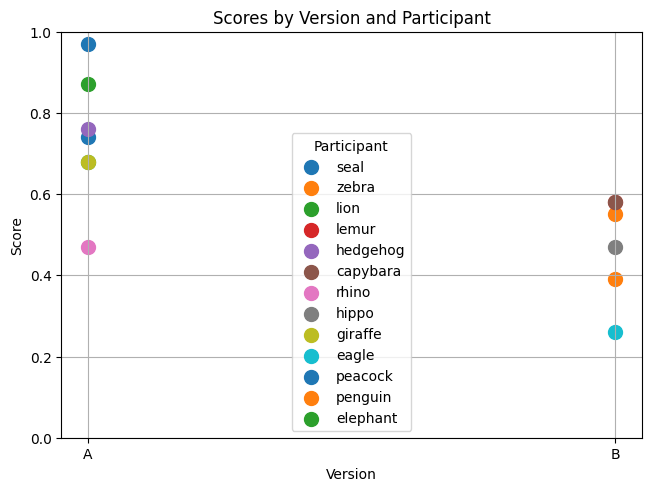

In [4]:
fig, ax = plt.subplots(layout='constrained')

# Loop through each participant and plot their scores
for participant in df_f['id'].unique():
    # Filter the DataFrame for the current participant
    participant_data = df_f[df_f['id'] == participant]
    
    # Plot the scores for this participant
    plt.scatter(participant_data['version'], participant_data['score'], label=participant, s=100)

# Add labels and title
ax.set_title('Scores by Version and Participant')
ax.set_xlabel('Version')
ax.set_ylabel('Score')
ax.set_ylim(0, 1)

# Show legend to differentiate participants
plt.legend(title='Participant')

# Show grid
plt.grid(True)

# Show the plot
plt.show()

In [12]:
df = pd.read_csv(f"out/study/combined4.csv")
df = df[(df["id"] != "rhino") & (df.pilot == 0) & (df["questionType"].notnull())]
df_a = df[(df.version == "A")]
df_b = df[(df.version == "B")]
df["reasonCorr"] = df.apply(lambda row: 0 if row["reasonCorrect"] != "right" else 1, axis=1)

In [13]:
# calculate average score for each question type for a student

# Create a new DataFrame for rows where questionType == 1 and score == 3
# (student correctly answered that there is NO MISTAKE in a CORRECT proof)
special_rows = df[(df['questionType'] == 1) & (df['score'] == 3)].copy()

# Distribute the score across questionType 1, 2, and 3
distributed_rows = pd.concat([
    special_rows.assign(score=special_rows['score'] / 3, questionType=1),
    special_rows.assign(score=special_rows['score'] / 3, questionType=2),
    special_rows.assign(score=special_rows['score'] / 3, questionType=3)
])

# Remove the original rows where questionType == 1 and score == 3 from the main DataFrame
df = df[~((df['questionType'] == 1) & (df['score'] == 3))]

# Append the distributed rows to the main DataFrame
df = pd.concat([df, distributed_rows])

# Now group by 'id' and 'questionType', summing up the scores and copying the version
qscores = df.groupby(['id', 'questionType']).agg(
    points=('score', 'sum'),
    version=('version', 'first'), # Assuming 'version' is consistent for each 'id'
    time=('time_elapsed', 'mean'),
    reason=('reasonCorr', 'sum')
).reset_index()

total_scores = {1: 8, 2: 8, 3: 8, 4: 7, 5: 7}
qscores['score'] = qscores.apply(lambda row: row['points'] / total_scores[row["questionType"]], axis=1)
qscores['reasoning'] = qscores.apply(lambda row: row['reason'] / total_scores[row["questionType"]], axis=1)
qscores = qscores.merge(df_f[['id', 'pretest']], on='id', how='left')
qscores.to_csv("out/study/questionTypeDataWithReasons2.csv")
# qscores.head(70)

In [9]:
# calculate average score and time taken for each question type
qdf = qscores.groupby(['questionType', 'version']).agg(
    points=('score', 'mean'),
    pointssd=('score', 'std'),
    time=('time', 'mean'),
    timesd=('time', 'std')
).reset_index()
#qdf.to_csv("out/study/questionType1roweach.csv")
qdf

,questionType,version,points,pointssd,time,timesd
0,1.0,A,0.854167,0.146131,19.621292,13.606052
1,1.0,B,0.416667,0.151383,28.821042,14.749829
2,2.0,A,0.770833,0.166145,18.121211,11.577928
3,2.0,B,0.333333,0.151383,26.137486,12.102292
4,3.0,A,0.645833,0.200260,34.299451,8.653550
5,3.0,B,0.229167,0.094097,31.443503,8.578480
6,4.0,A,0.809524,0.147542,21.583357,2.287145
7,4.0,B,0.666667,0.195180,28.685833,3.955382
8,5.0,A,0.857143,0.221313,30.137143,16.156007
9,5.0,B,0.785714,0.267261,36.060290,10.553171


In [10]:
df = pd.read_csv("out/study/combined4.csv")
# Check times where student got question right with the wrong reason
df = df[(df["pilot"] == 0) & (~df["proof"].str.startswith("P"))]
select = df[(df["score"] > 0) & (df["reasonCorrect"] == 0) & (df["question"] != "qID-0")]
select

,id,question,version,time_elapsed,proof,score,pilot,order,questionText,reasoning,cues,steps,reasonCorrect,understanding,misconception,questionType


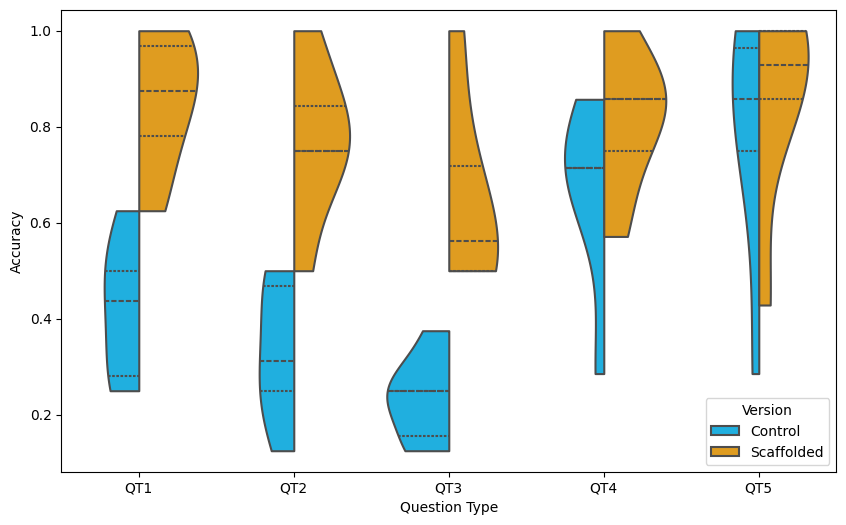

In [16]:
df = pd.read_csv("out/study/questionTypeDataWithReasons2.csv")
df["version"] = df["version"].replace("B", "Control")
df["version"] = df["version"].replace("A", "Scaffolded")
df["questionType"] = df['questionType'].astype(str)
df["questionType"] = df['questionType'].apply(lambda x: f"QT{x.strip('.0')}")
# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

# Left half for version C
g = sns.violinplot(
    x="questionType", 
    y="score", 
    hue="version",
    data=df,
    split=True,
    linewidth=1.5,
    cut=0,
    palette={"Control": "deepskyblue", "Scaffolded": "orange"},
    inner="quart",
    ax=ax
)
ax.set(xlabel='Question Type', ylabel='Accuracy')
ax.legend(title="Version")
sns.move_legend(ax, "lower right")
fig = g.get_figure()
fig.savefig("plots/questionTypeViolin2.png", bbox_inches='tight') 

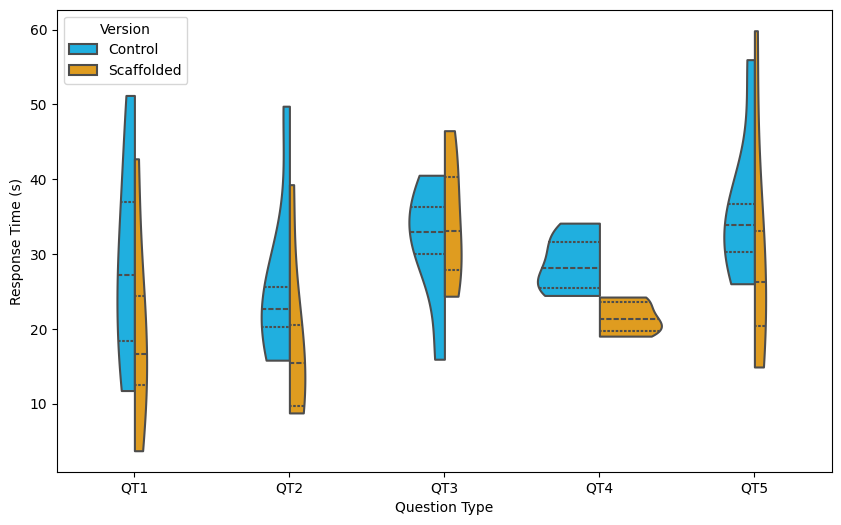

In [15]:
fig, ax = plt.subplots(figsize=(10, 6))

g = sns.violinplot(
    x="questionType", 
    y="time", 
    hue="version",
    data=df,
    split=True,
    linewidth=1.5,
    cut=0,
    palette={"Control": "deepskyblue", "Scaffolded": "orange"},
    inner="quart",
    ax=ax
)
ax.set(xlabel='Question Type', ylabel='Response Time (s)')
ax.legend(title="Version")
sns.move_legend(ax, "upper left")
fig = g.get_figure()
fig.savefig("plots/responseTimeViolin2.png", bbox_inches='tight') 